### Import & Load Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [2]:
df_customer = pd.read_csv('dataset_customer.csv')

In [3]:
df_product = pd.read_csv('dataset_product.csv')

In [4]:
df_store = pd.read_csv('dataset_store.csv')

In [5]:
df_transaction = pd.read_csv('dataset_transaction.csv')

### Data Cleansing

In [6]:
df_customer['Income'] = df_customer['Income'].replace('[,]','.',regex=True).astype(float)
df_customer.head()

,CustomerID,Age,Gender,Marital Status,Income
0,1,55,1,Married,5.0
1,2,60,1,Married,6.0
2,3,32,1,Married,9.0
3,4,31,1,Married,4.0
4,5,58,1,Married,3.0


In [7]:
df_store['Latitude'] = df_store['Latitude'].replace('[,]','.',regex=True).astype(float)
df_store['Longitude'] = df_store['Longitude'].replace('[,]','.',regex=True).astype(float)
df_store.head()

,StoreID,StoreName,GroupStore,Type,Latitude,Longitude
0,1,Prima Tendean,Prima,Modern Trade,-6.0,NaN
1,2,Prima Kelapa Dua,Prima,Modern Trade,-6.0,NaN
2,3,Prima Kota,Prima,Modern Trade,-7.0,NaN
3,4,Gita Ginara,Gita,General Trade,-6.0,NaN
4,5,Bonafid,Gita,General Trade,-7.0,NaN


In [8]:
df_transaction['Date'] = pd.to_datetime(df_transaction['Date'], format='%d/%m/%Y')
df_transaction.head()

,TransactionID,CustomerID,Date,ProductID,Price,Qty,TotalAmount,StoreID
0,TR11369,328,2022-01-01,P3,7500,4,30000,12
1,TR16356,165,2022-01-01,P9,10000,7,70000,1
2,TR1984,183,2022-01-01,P1,8800,4,35200,4
3,TR35256,160,2022-01-01,P1,8800,7,61600,4
4,TR41231,386,2022-01-01,P9,10000,1,10000,4


### Data Merge

In [9]:
df_merge = pd.merge(df_transaction, df_customer, on='CustomerID')
df_merge = pd.merge(df_merge, df_store, on='StoreID')
df_merge = pd.merge(df_merge, df_product, on='ProductID')

df_merge.head()

,TransactionID,CustomerID,Date,ProductID,Price_x,Qty,TotalAmount,StoreID,Age,Gender,Marital Status,Income,StoreName,GroupStore,Type,Latitude,Longitude,Product Name,Price_y
0,TR11369,328,2022-01-01,P3,7500,4,30000,12,36,0,Married,10.0,Prestasi Utama,Prestasi,General Trade,-2.0,NaN,Crackers,7500
1,TR16356,165,2022-01-01,P9,10000,7,70000,1,44,1,Married,14.0,Prima Tendean,Prima,Modern Trade,-6.0,NaN,Yoghurt,10000
2,TR1984,183,2022-01-01,P1,8800,4,35200,4,27,1,Single,0.0,Gita Ginara,Gita,General Trade,-6.0,NaN,Choco Bar,8800
3,TR35256,160,2022-01-01,P1,8800,7,61600,4,48,1,Married,12.0,Gita Ginara,Gita,General Trade,-6.0,NaN,Choco Bar,8800
4,TR41231,386,2022-01-01,P9,10000,1,10000,4,33,0,Married,6.0,Gita Ginara,Gita,General Trade,-6.0,NaN,Yoghurt,10000


### Data Frame Clustering

In [10]:
df_cluster = df_merge.groupby(['CustomerID']).agg({
    'TransactionID': 'count',
    'Qty': 'sum',
    'TotalAmount': 'sum'
}).reset_index()

df_cluster.head()

,CustomerID,TransactionID,Qty,TotalAmount
0,1,17,60,623300
1,2,13,57,392300
2,3,15,56,446200
3,4,10,46,302500
4,5,7,27,268600


### Standardizing Data

In [11]:
# Ensure the data is standardized
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_cluster[['TransactionID', 'Qty', 'TotalAmount']])

### Determining the Number of Clusters with the Elbow Method

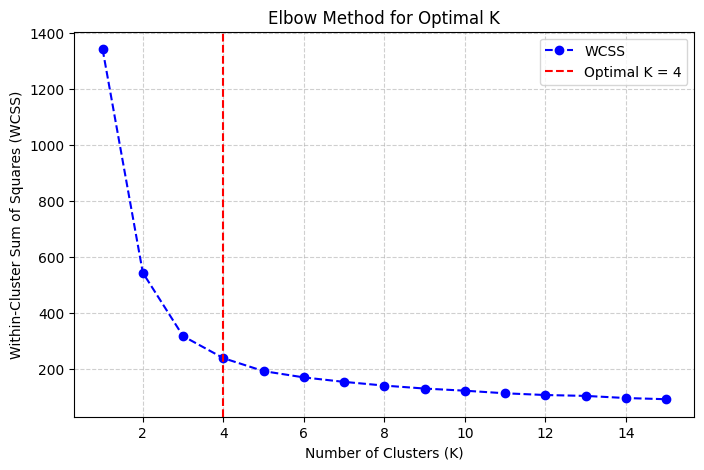

In [12]:
# Trying different cluster numbers from 1 to 15
wcss = []
K_range = range(1, 16)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(df_scaled)
    wcss.append(kmeans.inertia_)

# Plot Elbow Method with Grid
plt.figure(figsize=(8,5))
plt.plot(K_range, wcss, marker='o', linestyle='--', color='b', label='WCSS')

# Determine the elbow point (check after plotting)
optimal_k = 4
plt.axvline(x=optimal_k, color='r', linestyle='--', label=f'Optimal K = {optimal_k}')

plt.grid(True, linestyle='--', alpha=0.6)
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.title('Elbow Method for Optimal K')
plt.legend()
plt.show()

### Clustering

In [13]:
# Clustering with the Optimal Number of Clusters
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df_cluster['Cluster'] = kmeans.fit_predict(df_scaled)

In [14]:
# Silhouette Score

from sklearn.metrics import silhouette_score

sil_score = silhouette_score(df_scaled, df_cluster['Cluster'])
print(f'Silhouette Score: {sil_score:.3f}')

Silhouette Score: 0.377


In [17]:
df_cluster['Cluster'] = kmeans.labels_

df_cluster.groupby(['Cluster']).agg({
    'CustomerID' : 'count',
    'TransactionID': 'mean',
    'Qty': 'mean',
    'TotalAmount': 'mean'
})

,CustomerID,TransactionID,Qty,TotalAmount
Cluster,,,,
0,114,13.254386,49.078947,436203.508772
1,93,7.021505,24.505376,208283.870968
2,180,10.427778,37.350000,325663.333333
3,60,16.316667,61.650000,572100.000000


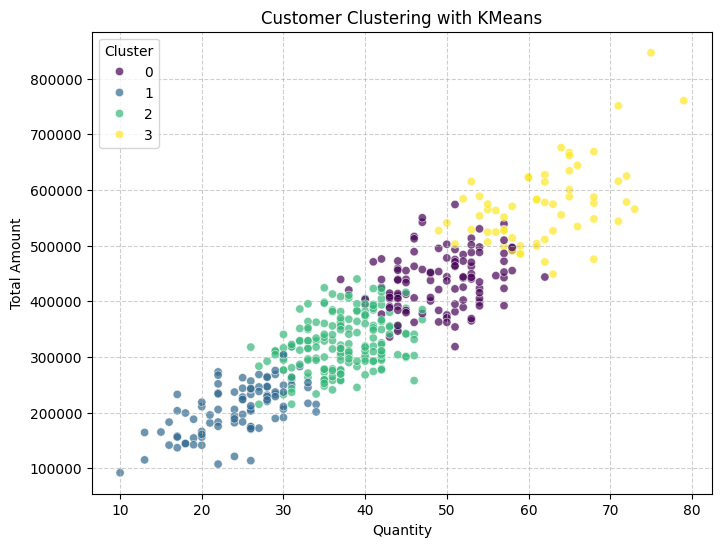

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))

# Scatter plot using Seaborn
sns.scatterplot(data=df_cluster, x='Qty', y='TotalAmount', hue='Cluster', palette='viridis', alpha=0.7)

# Add grid to make the boxes visible
plt.grid(True, linestyle='--', alpha=0.6)

plt.xlabel('Quantity')
plt.ylabel('Total Amount')
plt.title('Customer Clustering with KMeans')
plt.legend(title='Cluster')

plt.show()